In [1]:
%pip install opencv-python
%pip install scikit-learn
%pip install tensorflow
%pip install matplotlib
import tensorflow as tf
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Parameters
CLASSES = ["apple", "calculator", "water_bottle", "food_box"]  # 4 classes from paper
IMG_SIZE = (8, 8)  # Target ultra-low resolution
DATA_PATH = "../../../dataset/rgbd-dataset"  # Base path to your dataset


def get_bbox_from_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return None
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    x,y,w,h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    return x,y,w,h


def load_depth_maps(class_names, data_path):
    images, labels = [], []
    
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        
        for instance_folder in sorted(os.listdir(class_path)):
            instance_path = os.path.join(class_path, instance_folder)
            if not os.path.isdir(instance_path):
                continue

            # Process each _depth.png and match with its _mask.png
            for file in sorted(os.listdir(instance_path)):
                if file.endswith("_depthcrop.png"):
                    base_prefix = file.replace("_depthcrop.png", "")
                    depth_path = os.path.join(instance_path, file)
                    mask_path = os.path.join(instance_path, f"{base_prefix}_maskcrop.png")

                    # Check if both files exist
                    if not os.path.isfile(depth_path) or not os.path.isfile(mask_path):
                        print(f"Missing pair for {file}")
                        continue

                    # Get bounding box from corresponding mask
                    bbox = get_bbox_from_mask(mask_path)
                    print(file)
                    print(mask_path)
                    if not bbox:
                        print(f"Invalid or empty mask for {mask_path}")
                        continue
                    x, y, w, h = bbox

                    # Load and crop depth image
                    depth_img = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
                    if depth_img is None or depth_img.shape == ():
                        print(f"Invalid depth image at {depth_path}")
                        continue

                    height, width = depth_img.shape
                    x1, y1 = max(0, x), max(0, y)
                    x2, y2 = min(width, x + w), min(height, y + h)

                    if x2 <= x1 or y2 <= y1:
                        print(f"Invalid bbox in {depth_path}")
                        continue

                    cropped = depth_img[y1:y2, x1:x2]
                    resized = cv2.resize(cropped, IMG_SIZE, interpolation=cv2.INTER_AREA)
                    normalized = resized.astype('float32') / 4000.0  # Adjust if needed

                    images.append(normalized)
                    labels.append(label)
    
    return np.array(images), np.array(labels)

    
    

# Load the data
print("Loading data...")
X, y = load_depth_maps(CLASSES, DATA_PATH)
X = X.reshape(-1, 8, 8, 1)  # Reshape for CNN input




Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scikit-learn in c:\users\sebas\appdata\local\programs\python\python310\lib\site-packages (1.6.1)




[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Loading data...
apple_1_1_100_depthcrop.png
../../../dataset/rgbd-dataset\apple\apple_1\apple_1_1_100_maskcrop.png
apple_1_1_101_depthcrop.png
../../../dataset/rgbd-dataset\apple\apple_1\apple_1_1_101_maskcrop.png
apple_1_1_102_depthcrop.png
../../../dataset/rgbd-dataset\apple\apple_1\apple_1_1_102_maskcrop.png
apple_1_1_103_depthcrop.png
../../../dataset/rgbd-dataset\apple\apple_1\apple_1_1_103_maskcrop.png
apple_1_1_104_depthcrop.png
../../../dataset/rgbd-dataset\apple\apple_1\apple_1_1_104_maskcrop.png
apple_1_1_105_depthcrop.png
../../../dataset/rgbd-dataset\apple\apple_1\apple_1_1_105_maskcrop.png
apple_1_1_106_depthcrop.png
../../../dataset/rgbd-dataset\apple\apple_1\apple_1_1_106_maskcrop.png
apple_1_1_107_depthcrop.png
../../../dataset/rgbd-dataset\apple\apple_1\apple_1_1_107_maskcrop.png
apple_1_1_108_depthcrop.png
../../../dataset/rgbd-dataset\apple\apple_1\apple_1_1_108_maskcrop.png
apple_1_1_109_depthcrop.png

In [ ]:
c

In [3]:

# Split data (70% train, 15% val, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

print("\nData loaded successfully!")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")


Data loaded successfully!
Training data shape: (14872, 10, 10, 1)
Validation data shape: (3187, 10, 10, 1)
Test data shape: (3188, 10, 10, 1)


In [4]:
print("Label counts:", np.unique(y, return_counts=True))

Label counts: (array([0, 1, 2, 3]), array([3098, 2934, 5691, 9524]))


In [5]:
import tensorflow as tf
'''
from tensorflow.keras import layers, models

# Definir entrada
inputs = tf.keras.Input(shape=(10, 10, 1))

# Primera capa Conv2D
x = layers.Conv2D(3, (3, 3), activation='relu', padding='valid')(inputs)
x = layers.Dropout(0.25)(x)

# Segunda capa Conv2D
x = layers.Conv2D(4, (3, 3), activation='relu', padding='valid')(x)
x = layers.Dropout(0.25)(x)

# Clasificador
x = layers.Flatten()(x)
outputs = layers.Dense(4, activation='softmax')(x)

# Modelo funcional completo
model = tf.keras.Model(inputs=inputs, outputs=outputs)

'''
model = tf.keras.Sequential([
    # Input: 8x8x1 (normalized depth maps)
    tf.keras.layers.Conv2D(
        filters=3,                  # 3 kernels (paper: "3 channels")
        kernel_size=(3, 3),         # 3x3 convolutions
        activation='relu',
        padding='valid',             # Preserves spatial dimensions (8x8)
        input_shape=(10, 10, 1)       # Input shape
    ),
    tf.keras.layers.Dropout(0.25),  # 25% dropout (paper: after each conv layer)
    
    # Second conv layer
    tf.keras.layers.Conv2D(
        filters=4,                  # 4 kernels (paper: "4 channels")
        kernel_size=(3, 3),
        activation='relu',
        padding='valid'             # No padding → output shrinks to 6x6
    ),
    tf.keras.layers.Dropout(0.25),
    
    # Classifier
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(
        units=4,                    # 4 classes (apple, calculator, water_bottle, food_box)
        activation='softmax'
    )
])
#'''

c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
from sklearn.utils.class_weight import compute_class_weight
y_train_classes = np.argmax(y_train, axis=1)
#model
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),  # SGD (not Adam!) for stability
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Compute class weights
best_acc=0
best_weights = [0,0]

class_weights = {0:4.0,
                1:5.0,
                2:2.0,
                3:2.0}

# Convert to dictionary format expected by Keras
#class_weights = dict(enumerate(class_weights))

history = model.fit(
    X_train, y_train,
    epochs=300,                     # Paper used 300 epochs
    batch_size=32,                  # Paper: 32 for 4 classes
    validation_data=(X_val, y_val),
    class_weight=class_weights,     # Your computed weights
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch, lr: lr * 0.5 if (epoch + 1) % 15 == 0 else lr  # LR decay every 15 epochs
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=6,
            restore_best_weights=True
        )
    ]
)
last_train_acc = history.history['accuracy'][-1]
if best_acc<=last_train_acc:
    best_acc = last_train_acc

print("Mejor precision:",best_acc)
#print("Mejor peso water bottle:",best_weights[0])
#print("Mejor peso food box:", best_weights[1])

Epoch 1/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3522 - loss: 3.7460 - val_accuracy: 0.4383 - val_loss: 1.3515 - learning_rate: 0.0010
Epoch 2/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4514 - loss: 3.6617 - val_accuracy: 0.4405 - val_loss: 1.3261 - learning_rate: 0.0010
Epoch 3/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4555 - loss: 3.6021 - val_accuracy: 0.4409 - val_loss: 1.2991 - learning_rate: 0.0010
Epoch 4/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4515 - loss: 3.5494 - val_accuracy: 0.4415 - val_loss: 1.2588 - learning_rate: 0.0010
Epoch 5/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4443 - loss: 3.4486 - val_accuracy: 0.4885 - val_loss: 1.1961 - learning_rate: 0.0010
Epoch 6/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4953 - loss: 3.2842 - val_accuracy: 0.7076 - val_loss: 1.0729 - learning_rate: 0.0010
Epoch 7/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5997 - loss: 2.

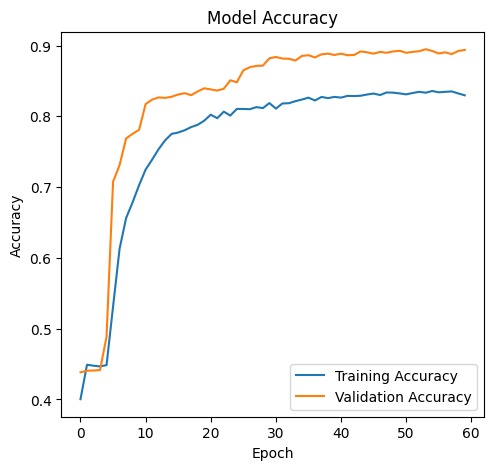

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


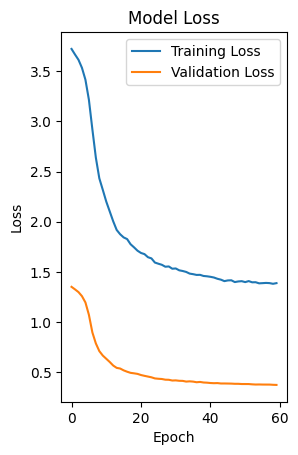

In [8]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [9]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9130 - loss: 0.3560
Test Accuracy: 0.8999, Test Loss: 0.3692


Note: you may need to restart the kernel to use updated packages.
  1/100 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
True class counts: [ 483  427  870 1408]
Predicted class counts: [ 596  380  883 1329]
Raw CM (counts):
 [[ 464    0    0   19]
 [  43  316   23   45]
 [   1   29  832    8]
 [  88   35   28 1257]]


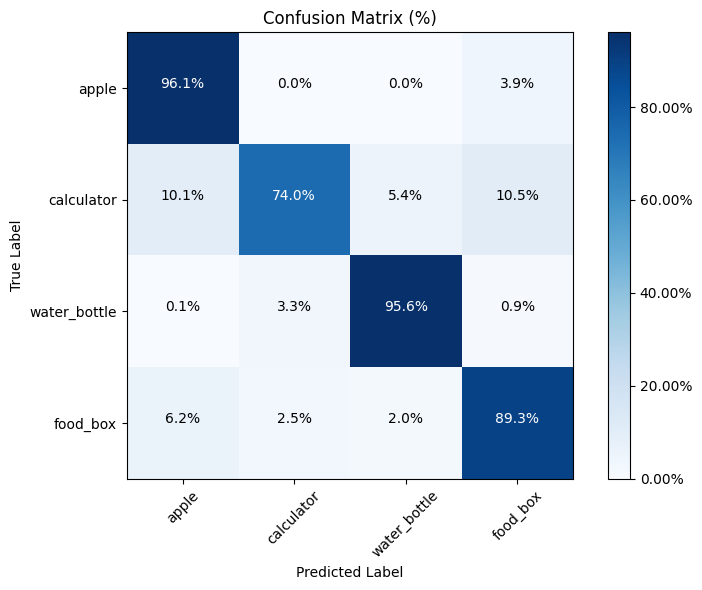

In [10]:
from sklearn.metrics import confusion_matrix
%pip install seaborn
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Check class distribution in true labels
print("True class counts:", np.bincount(y_true_classes))

# Check class distribution in predictions
print("Predicted class counts:", np.bincount(y_pred_classes))

# Check raw confusion matrix (counts)
print("Raw CM (counts):\n", confusion_matrix(y_true_classes, y_pred_classes))





class_names=["apple","calculator","food box","water bottle"]
# Compute confusion matrix (raw counts)
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Convert to percentages (row-wise: % of predictions per true class)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(cm_percent, interpolation='nearest', cmap='Blues')
plt.colorbar(format='%.2f%%')

# Add labels
class_names = ['apple', 'calculator', 'water_bottle', 'food_box']  # Replace with your class names
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Annotate cells with percentages
thresh = cm_percent.max() / 2.
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        plt.text(j, i, f'{cm_percent[i, j]:.1f}%',
                 horizontalalignment="center",
                 color="white" if cm_percent[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%)')
plt.tight_layout()
plt.show()

In [11]:
unique, counts = np.unique(y_true_classes, return_counts=True)
print("Class distribution:", dict(zip(class_names, counts)))

Class distribution: {'apple': np.int64(483), 'calculator': np.int64(427), 'water_bottle': np.int64(870), 'food_box': np.int64(1408)}


In [ ]:
print(X_test.shape)
print(model.input_shape)
model.summary()

(3188, 10, 10, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 3)        │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 6, 4)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724 (2.83 KB)

 Trainable params: 722 (2.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:

first_conv_layer = model.layers[0]  # Index 0 is your first Conv2D layer

# Get the weights (kernels and biases) of the first layer
first_layer_weights = first_conv_layer.get_weights()

# The weights are returned as a list where:
# first_conv_layer_weights[0] contains the kernels (filters)
# first_conv_layer_weights[1] contains the biases
kernels_first_layer = first_layer_weights[0]
biases_first_layer = first_layer_weights[1]

print("First layer kernels shape:", kernels_first_layer.shape)
# Should print (3, 3, 1, 3) because:
# (kernel_height, kernel_width, input_channels, output_channels)

# Similarly for the second convolutional layer
second_conv_layer = model.layers[2]  # Index 2 (after Dropout)
second_layer_weights = second_conv_layer.get_weights()
kernels_second_layer = second_layer_weights[0]

print("Second layer kernels shape:", kernels_second_layer.shape)
# Should print (3, 3, 3, 4) because:
# (kernel_height, kernel_width, input_channels (from previous layer), output_channels)

Shape del Kernel: (3, 3, 1, 3)
Shape del bias: (3,)
First layer kernels shape: (3, 3, 1, 3)
Second layer kernels shape: (3, 3, 3, 4)


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Asegúrate de tener la lista CLASSES definida
CLASSES = ["apple", "calculator", "water_bottle", "food_box"]

for i in range(len(X_test)):
    pred_class = np.argmax(preds[i])
    true_class = np.argmax(y_test[i])
    
    if pred_class == true_class:
        plt.imshow(X_test[i].squeeze(), cmap='gray')
        plt.title(f"True: {CLASSES[true_class]}, Pred: {CLASSES[pred_class]}")
        plt.axis('off')
        plt.show()

NameError: name 'preds' is not defined